In [1]:
import keras

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))


Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6640926380307811732
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13456586123446743116
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6531337689
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14797333840686881826
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5672316697510377623
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf 

In [8]:
import pathlib

### Load images

In [9]:
data_dir = pathlib.Path('archive/brain_tumor_dataset')

In [10]:
data_dir 

WindowsPath('archive/brain_tumor_dataset')

In [11]:
for name in data_dir.glob('*\*.*'):
    print(name)

archive\brain_tumor_dataset\no\1 no.jpeg
archive\brain_tumor_dataset\no\10 no.jpg
archive\brain_tumor_dataset\no\11 no.jpg
archive\brain_tumor_dataset\no\12 no.jpg
archive\brain_tumor_dataset\no\13 no.jpg
archive\brain_tumor_dataset\no\14 no.jpg
archive\brain_tumor_dataset\no\15 no.jpg
archive\brain_tumor_dataset\no\17 no.jpg
archive\brain_tumor_dataset\no\18 no.jpg
archive\brain_tumor_dataset\no\19 no.jpg
archive\brain_tumor_dataset\no\2 no.jpeg
archive\brain_tumor_dataset\no\20 no.jpg
archive\brain_tumor_dataset\no\21 no.jpg
archive\brain_tumor_dataset\no\22 no.jpg
archive\brain_tumor_dataset\no\23 no.jpg
archive\brain_tumor_dataset\no\24 no.jpg
archive\brain_tumor_dataset\no\25 no.jpg
archive\brain_tumor_dataset\no\26 no.jpg
archive\brain_tumor_dataset\no\27 no.jpg
archive\brain_tumor_dataset\no\28 no.jpg
archive\brain_tumor_dataset\no\29 no.jpg
archive\brain_tumor_dataset\no\3 no.jpg
archive\brain_tumor_dataset\no\30 no.jpg
archive\brain_tumor_dataset\no\31 no.jpg
archive\brain_tum

In [12]:
image_count = len(list(data_dir.glob('*\*.*')))
print(image_count)

253


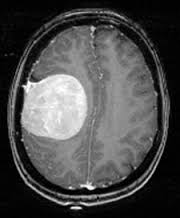

In [13]:
image_yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(image_yes[0]))

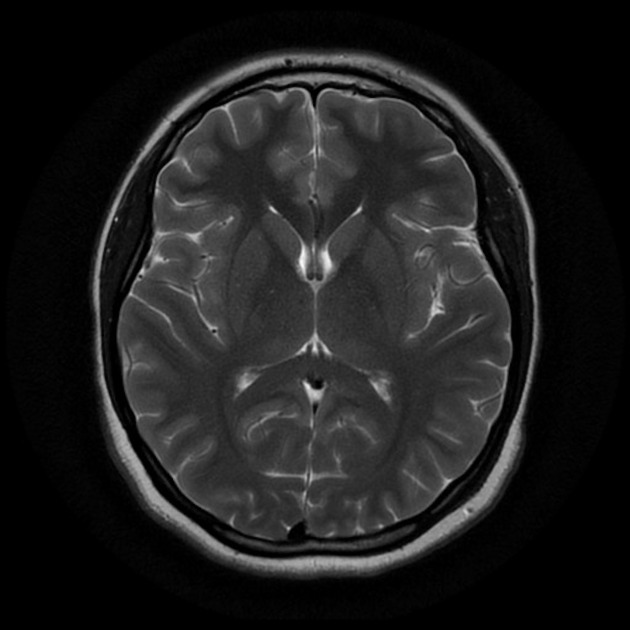

In [14]:
image_no = list(data_dir.glob('no/*'))
PIL.Image.open(str(image_no[0]))

### Build dataset

In [15]:
batch_size = 32
img_height, img_width = 128, 128

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [17]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## Visualize  data

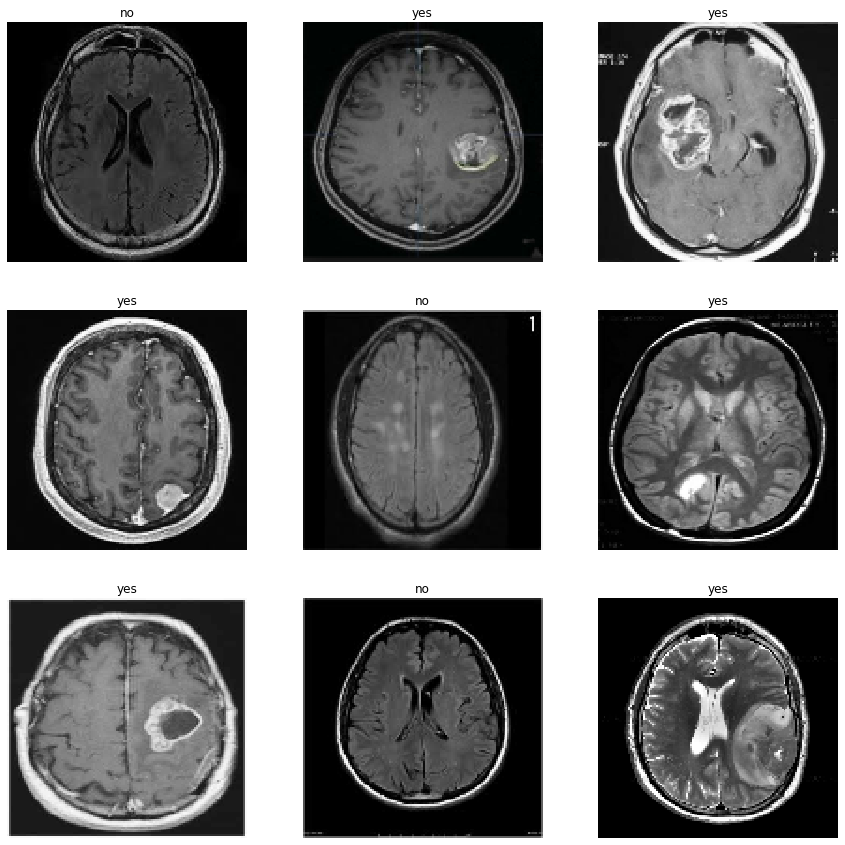

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.121596396 1.0


## Training model

In [23]:
num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  #layers.SpatialDropout2D(0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  #layers.SpatialDropout2D(0.5),
  #layers.Conv2D(32, 3, activation='relu'),
  #layers.MaxPooling2D(),
  #layers.SpatialDropout2D(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[callback],
)

Epoch 1/30
7/7 [==============================] - 1s 86ms/step - loss: 1.0213 - accuracy: 0.4631 - val_loss: 0.5919 - val_accuracy: 0.7600
Epoch 2/30
7/7 [==============================] - 0s 39ms/step - loss: 0.5285 - accuracy: 0.7389 - val_loss: 0.5415 - val_accuracy: 0.7600
Epoch 3/30
7/7 [==============================] - 0s 40ms/step - loss: 0.4733 - accuracy: 0.8079 - val_loss: 0.5472 - val_accuracy: 0.7800
Epoch 4/30
7/7 [==============================] - 0s 39ms/step - loss: 0.3981 - accuracy: 0.8177 - val_loss: 0.5454 - val_accuracy: 0.7800
Epoch 5/30
7/7 [==============================] - 0s 38ms/step - loss: 0.2953 - accuracy: 0.8670 - val_loss: 0.5129 - val_accuracy: 0.8400
Epoch 6/30
7/7 [==============================] - 0s 40ms/step - loss: 0.2240 - accuracy: 0.9360 - val_loss: 0.5329 - val_accuracy: 0.8400
Epoch 7/30
7/7 [==============================] - 0s 39ms/step - loss: 0.1371 - accuracy: 0.9852 - val_loss: 0.6293 - val_accuracy: 0.8400
Epoch 8/30
7/7 [===========

In [27]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

<ipython-input-62-f8618f4dcb6d>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(10, 5, idx + i + 1)


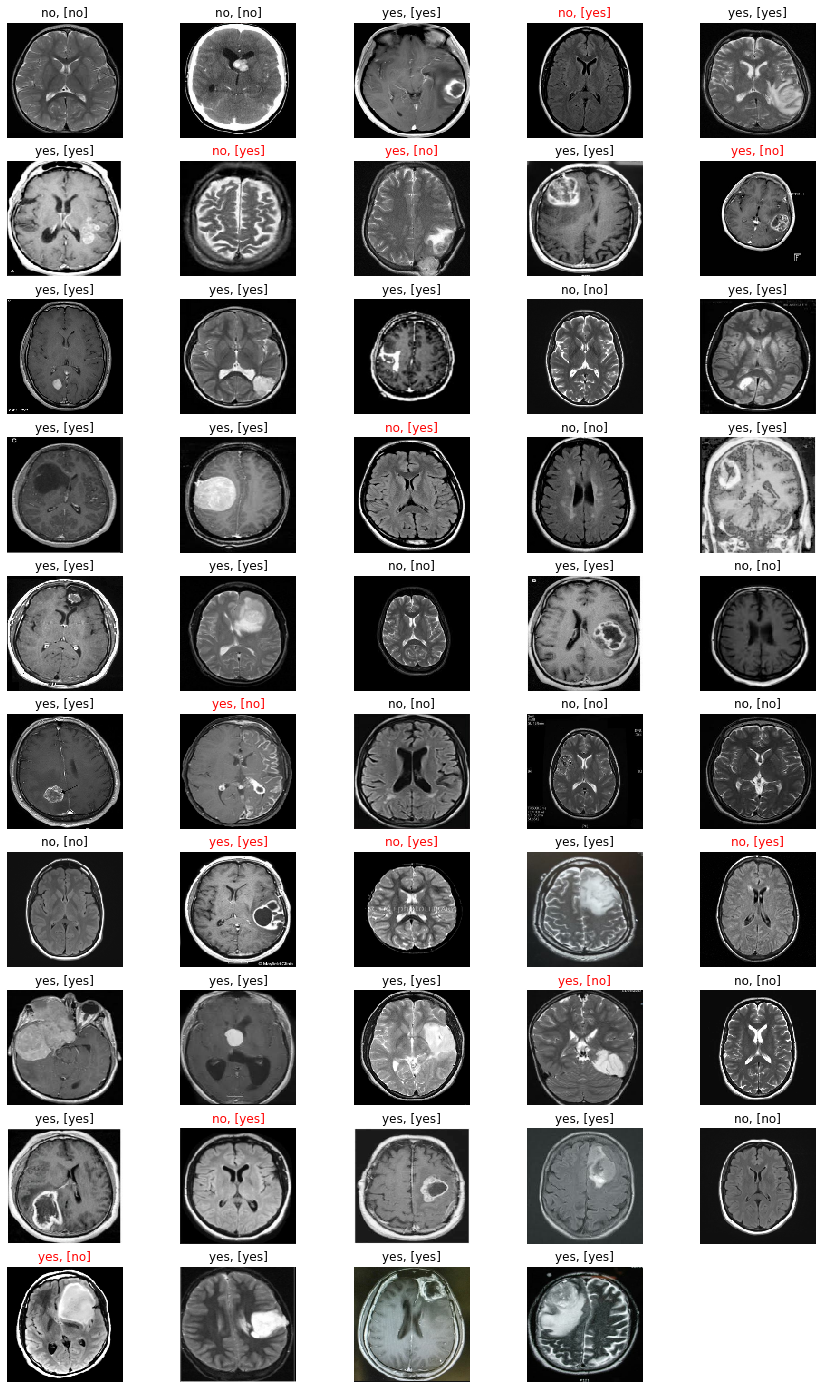

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 25))
idx=0
for images, labels in val_ds:
    preds = model.predict(images)
    pred_category = tf.argmax(preds, 1).numpy()
    for i in range(len(images)):
        #print(i)
        ax = plt.subplot(10, 5, idx + i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        correct = class_names[labels[i]] ==  class_names[pred_category[i]]
        if not correct:
            plt.title(class_names[labels[i]] + ", [" + class_names[pred_category[i]] + "]", color='r')
        else:
            plt.title(class_names[labels[i]] + ", [" + class_names[pred_category[i]] + "]")
        plt.axis("off")
    idx += i
